# **Introduction**

The project "Africa Cropland Mapping ML Training" aims to create comprehensive annotated high-resolution satellite imagery datasets to delineate the boundaries of agricultural fields across Sub-Saharan Africa, providing data for machine learning model training. From 2016 onwards, Using Planet imagery mosaics with high spatial and temporal resolution, >37,000 cells were collected across nine agroecoregions and stratified to include both cropland and non-cropland.


**Objective 1**: Implement different label combinations and a 70-20-10 train-validate-test split. Using RScore or QScore, ensure that higher-quality data is used for testing and validation while lower-quality data is used for training. Specifically, for RScore, retain Class 1a and 2 assignments and the highest-scoring assignments for Class 1b, 1d, and 4. For QScore, rely on the label quality control platform.


**Objective 2**: Test different model architectures, including Res-U-Net and U-Net with a ResNext backbone. Begin by training the Fieldmapper U-Net, then adapt to a Res-U-Net, and potentially explore enhancements like attention mechanisms.

This notebook focuses on objective 2 of the project, using the Res-U-Net model architecture. The authors of this notebook are Mobeen Akhtar and Antonio Fonseca.

# **Method: Res-U-Net model architeture**

Res-U-Net is a deep neural network architecture designed for image segmentation, combining features of the U-Net and ResNet networks. It retains the coding-decoding structure characteristic of U-Net, but incorporates residual blocks, inspired by ResNet, which facilitate the propagation of gradients over multiple deep layers.

These residual blocks help combat gradient disappearance and improve learning capacity, making the network more effective at detecting relevant features and preserving details. In addition, skip connections between the encoder and decoder allow fine details to be recovered during segmentation.

Res-U-Net is often cited as an efficient approach for image segmentation tasks, combining the efficiency of the ResNet backbone with the robustness and effectiveness of U-Net, as exemplified in the work of Diakogiannis et al. (2020), where the architecture is used for land cover mapping.

The model was configured with 6 input channels, allowing it to process multiple spectral bands of satellite images, and with 2 output channels, corresponding to the number of segmentation classes. Each residual block, implemented in the ResBlock class, includes 2D convolutions (Conv2D), batch normalization (BatchNorm2D), and ReLU activation.

The ResUNet architecture consists of an encoder and a decoder, both utilizing four residual blocks. The encoder progressively reduces resolution while extracting important features, and the decoder uses upsampling to increase resolution and reconstruct the segmented image. Skip connections between the encoder and decoder help preserve details, resulting in more accurate segmentation. The model employs the CrossEntropyLoss function and is optimized with the Adam optimizer, supported by a StepLR learning rate scheduler.

# **Results/analysis**

# **Dicusssion**

# **1. Setup and Imports**
**Description**: Import necessary libraries and set up the workspace. This includes mounting Google Drive, defining the data directory, and ensuring all required tools are available.

In [1]:
# Import essential libraries for deep learning and data handling
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import random
from google.colab import drive

# Libraries for image handling and visualization
!pip install rasterio
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import cv2

# Additional utilities
import logging
import tqdm
from datetime import datetime
import itertools
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.1 MB/s eta 0:00:00


In [4]:
# Setup for mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Directory where the data is stored
data_dir = "/content/gdrive/My Drive/adleo_my/final_project/data"

# Paths to images, labels, and catalog
image_paths = list(Path(data_dir).glob("images/*.tif"))
label_paths = list(Path(data_dir).glob("labels/*.tif"))
catalog_paths = pd.read_csv(os.path.join(data_dir, "label-catalog-filtered.csv"))

# Check if all paths are valid lists
if not all(isinstance(path_list, list) for path_list in (image_paths, label_paths)):
    raise ValueError("Both image_paths and label_paths must be lists.")

# Prints valid number of images and labels
print("No. of images:",len(image_paths), "\n",
      "No. of labels:", len(label_paths),"\n",
      "No. of rows in cataloge:", len(catalog_paths))

# Ensure that paths are sorted and matched
image_paths.sort()
label_paths.sort()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-4-3c3f5701cbe8>:11: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  catalog_paths = pd.read_csv(os.path.join(data_dir, "label-catalog-filtered.csv"))


No. of images: 33873 
 No. of labels: 33756 
 No. of rows in cataloge: 33746


# **2. Utility Functions**

**Description**: Define auxiliary functions to handle, normalize, and visualize geographic image data. These include data loading, normalization, histogram visualization, and buffered window management.

2.1. Custom Error Handling

In [5]:
# Exception class to handle errors related to input
class InputError(Exception):
    def __init__(self, message):
        self.message = message
    def __str__(self):
        if self.message:
            return 'InputError, {} '.format(self.message)
        else:
            return 'InputError'

2.2 Data Loading and Normalization

In [6]:
# Function to load geographic data and optionally normalize or crop it
def load_data(data_path, usage="train", window=None, norm_stats_type=None, is_label=False):
    with rasterio.open(data_path, "r") as src:
        if is_label:
            # Read as a segmentation mask if `is_label` is true
            if src.count != 1:
                raise ValueError("Label shape not applicable: expected 1 channel")
            img = src.read(1)
        else:
            # Handle cases where the image is not a label
            nodata = src.nodata
            assert norm_stats_type in ["local_per_tile", "local_per_band", "global_per_band"]
            if norm_stats_type == "local_per_tile":
                img = mmnorm1(src.read(), nodata=nodata)
            elif norm_stats_type == "local_per_band":
                img = mmnorm2(src.read(), nodata=nodata, clip_val=1.5)
            elif norm_stats_type == "global_per_band":
                img = mmnorm3(src.read(), nodata=nodata, clip_val=1.5)

            # Crop the image if `usage` is "train" or "validate"
            if usage in ["train", "validate"] and window is not None:
                img = img[:, max(0, window[1]): window[1] + window[3], max(0, window[0]): window[0] + window[2]]

    return img

# Function to load and stack multiple geographic images together
def get_stacked_img(img_paths, usage, norm_stats_type="local_per_tile",
                    window=None):
    # Stack multiple image paths together if there are multiple images
    if len(img_paths) > 1:
        img_ls = [load_data(m, usage, window, norm_stats_type) for m in img_paths]
        img = np.concatenate(img_ls, axis=0).transpose(1, 2, 0)
    else:
        img = load_data(img_paths[0], usage, window, norm_stats_type).transpose(1, 2, 0)

    # Process the image stack for training or validation purposes
    if usage in ["train", "validate"]:
        col_off, row_off, col_target, row_target = window
        row, col, c = img.shape
        if row < row_target or col < col_target:
            row_off = abs(row_off) if row_off < 0 else 0
            col_off = abs(col_off) if col_off < 0 else 0
            canvas = np.zeros((row_target, col_target, c))
            canvas[row_off: row_off + row, col_off: col_off + col, :] = img
            return canvas
        else:
            return img
    elif usage == "predict":
        return img
    else:
        raise ValueError

# Function to normalize image data using a Min-Max approach
def min_max_normalize_image(image, dtype=np.float32):
    # Calculate the minimum and maximum values for each band to scale
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)

    # Return the normalized image
    return normalized_img

# Function to normalize image data using a Min-Max approach
def mmnorm1(img, nodata):
    img_tmp = np.where(img == nodata, np.nan, img)
    img_max = np.nanmax(img_tmp)
    img_min = np.nanmin(img_tmp)
    normalized = (img - img_min) / (img_max - img_min)
    normalized = np.clip(normalized, 0, 1)
    return normalized

# Function to normalize image data using a Min-Max approach with clipping
def mmnorm2(img, nodata, clip_val=None):
    nan_corr_img = np.where(img == nodata, np.nan, img)
    nan_corr_img = np.where(img == 0, np.nan, img)
    if clip_val > 0:
        left_tail_clip = np.nanpercentile(nan_corr_img, clip_val)
        right_tail_clip = np.nanpercentile(nan_corr_img, 100 - clip_val)
        left_clipped_img = np.where(img < left_tail_clip, left_tail_clip, img)
        clipped_img = np.where(left_clipped_img > right_tail_clip, right_tail_clip, left_clipped_img)
        normalized_bands = []
        for i in range(img.shape[0]):
            band_min = np.nanmin(clipped_img[i, :, :])
            band_max = np.nanmax(clipped_img[i, :, :])
            normalized_band = (clipped_img[i, :, :] - band_min) / (band_max - band_min)
            normalized_bands.append(np.expand_dims(normalized_band, 0))
        normal_img = np.concatenate(normalized_bands, 0)
    elif clip_val == 0 or clip_val is None:
        normalized_bands = []
        for i in range(img.shape[0]):
            band_min = np.nanmin(nan_corr_img[i, :, :])
            band_max = np.nanmax(nan_corr_img[i, :, :])
            normalized_band = (nan_corr_img[i, :, :] - band_min) / (band_max - band_min)
            normalized_bands.append(np.expand_dims(normalized_band, 0))
        normal_img = np.concatenate(normalized_bands, 0)
    else:
        raise ValueError("clip must be a non-negative decimal.")
    normal_img = np.clip(normal_img, 0, 1)
    return normal_img

    # Function to normalize data based on pre-defined min and max values for each band
def mmnorm3(img, nodata, clip_val=None):
    hardcoded_stats = {
        "mins": np.array([331.0, 581.0, 560.0, 1696.0]),
        "maxs": np.array([1403.0, 1638.0, 2076.0, 3652.0])
    }

    num_bands = img.shape[0]
    mins = hardcoded_stats["mins"]
    maxs = hardcoded_stats["maxs"]

    if clip_val:
        normalized_bands = []
        for i in range(num_bands):
            nan_corr_img = np.where(img[i, :, :] == nodata, np.nan, img[i, :, :])
            nan_corr_img = np.where(img[i, :, :] == 0, np.nan, img[i, :, :])
            left_tail_clip = np.nanpercentile(nan_corr_img, clip_val)
            right_tail_clip = np.nanpercentile(nan_corr_img, 100 - clip_val)
            left_clipped_band = np.where(img[i, :, :] < left_tail_clip, left_tail_clip, img[i, :, :])
            clipped_band = np.where(left_clipped_band > right_tail_clip, right_tail_clip, left_clipped_band)
            normalized_band = (clipped_band - mins[i]) / (maxs[i] - mins[i])
            normalized_bands.append(np.expand_dims(normalized_band, 0))
        img = np.concatenate(normalized_bands, 0)
    else:
        for i in range(num_bands):
            img[i, :, :] = (img[i, :, :] - mins[i]) / (maxs[i] - mins[i])
    img = np.clip(img, 0, 1)
    return img

2.3. Geographic Data Processing

In [7]:
# Function to get a buffered window to align source and destination images
def get_buffered_window(src_path, dst_path, buffer):
    with rasterio.open(src_path, "r") as src:
        gt_src = src.transform
    with rasterio.open(dst_path, "r") as dst:
        gt_dst = dst.transform
        w_dst = dst.width
        h_dst = dst.height
    col_off = round((gt_dst[2] - gt_src[2]) / gt_src[0]) - buffer
    row_off = round((gt_dst[5] - gt_src[5]) / gt_src[4]) - buffer
    width = w_dst + buffer * 2
    height = h_dst + buffer * 2
    return col_off, row_off, width, height

# Function to retrieve metadata for a specified image file while applying a buffer
def get_meta_from_bounds(file, buffer):
    with rasterio.open(file, "r") as src:
        meta = src.meta
        dst_width = src.width - 2 * buffer
        dst_height = src.height - 2 * buffer
        window = Window(buffer, buffer, dst_width, dst_height)
        win_transform = src.window_transform(window)
    meta.update({
        'width': dst_width,
        'height': dst_height,
        'transform': win_transform,
        'count': 1,
        'nodata': -128,
        'dtype': 'int8'
    })
    return meta

# Function to generate smaller chips from a larger image
def get_chips(img, dsize, buffer):
    h, w, _ = img.shape
    x_ls = range(0, h - 2 * buffer, dsize - 2 * buffer)
    y_ls = range(0, w - 2 * buffer, dsize - 2 * buffer)
    index = list(itertools.product(x_ls, y_ls))
    img_ls = []
    for i in range(len(index)):
        x, y = index[i]
        img_ls.append(img[x:x + dsize, y + dsize, :])
    return img_ls, index

2.4. Visualization Functions

In [8]:
# Function to visualize a histogram of image data distribution
def display_hist(img):
    img = mmnorm1(img)
    im = np.where(img == 0, np.nan, img)
    plt.hist(img.ravel(), 500, [np.nanmin(im), img.max()])
    plt.figure(figsize=(20, 20))
    plt.show()

# Function to visualize composites and labels
def display(img, label, mask):
    gsimg = (comp432_dis(img, "GS") * 255).permute(1, 2, 0).int()
    osimg = (comp432_dis(img, "OS") * 255).permute(1, 2, 0).int()
    _, figs = plt.subplots(1, 4, figsize=(20, 20))
    label = label.cpu()
    figs[0].imshow(gsimg)
    figs[1].imshow(osimg)
    figs[2].imshow(label)
    figs[3].imshow(mask)
    plt.show()

# Function to generate false color composites
def comp432_dis(img, season):
    viewsize = img.shape[1:]
    if season == "GS":
        b4 = mmnorm1(img[3, :, :].cpu().view(1, *viewsize), 0)
        b3 = mmnorm1(img[2, :, :].cpu().view(1, *viewsize), 0)
        b2 = mmnorm1(img[1, :, :].cpu().view(1, *viewsize), 0)
    elif season == "OS":
        b4 = mmnorm1(img[7, :, :].cpu().view(1, *viewsize), 0)
        b3 = mmnorm1(img[6, :, :].cpu().view(1, *viewsize), 0)
        b2 = mmnorm1(img[5, :, :].cpu().view(1, *viewsize), 0)
    else:
        raise ValueError("Bad season value")
    img = torch.cat([b4, b3, b2], 0)
    return img

2.5. Reproducibility and Logging

In [9]:
# Function to ensure reproducibility of results by setting consistent seeds
def make_reproducible(seed=42, cudnn=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if cudnn:
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

# Function to print progress messages and log them if a logger is provided
def progress_reporter(msg, verbose, logger=None):
    if verbose:
        print(msg)
    if logger:
        logger.info(msg)

# Function to set up a logger with a specific configuration
def setup_logger(log_dir, log_name, use_date=False):
    if use_date:
        dt = datetime.now().strftime("%d%m%Y_%H%M")
        log = "{}/{}_{}.log".format(log_dir, log_name, dt)
    else:
        log = "{}/{}.log".format(log_dir, log_name)
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    log_format = (f"%(asctime)s::%(levelname)s::%(name)s::%(filename)s::"
                  f"%(lineno)d::%(message)s")
    logging.basicConfig(filename=log, filemode='w',
                        level=logging.INFO, format=log_format)
    return logging.getLogger()

2.6. Pickle Serialization

In [10]:
# Function to save a dataset object as a serialized file
def pickle_dataset(dataset, file_path):
    with open(file_path, "wb") as fp:
        pickle.dump(dataset, fp)

# Function to load a dataset object from a serialized file
def load_pickle(file_path):
    return pd.read_pickle(file_path)

# **3. Data Preparation Classes and Functions**
**Description**: Implement data loading classes like datasetloader and functions for data augmentation (e.g., flipping, rotating) and patch generation.

3.1. Data Augmentation Functions

In [11]:
# Function to apply horizontal or vertical flip augmentation
def flip_image_and_label(image, label, flip_type):
    # Check the type of flip to apply
    if flip_type == 'hflip':
        # Apply horizontal flip to both the image and label
        flipped_image = cv2.flip(image, 1)
        flipped_label = cv2.flip(label, 1)
    elif flip_type == 'vflip':
        # Apply vertical flip to both the image and label
        flipped_image = cv2.flip(image, 0)
        flipped_label = cv2.flip(label, 0)
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
    # Return flipped image and label
    return flipped_image.copy(), flipped_label.copy()

# Function to apply rotation augmentation to an image and its label
def rotate_image_and_label(image, label, angle):
    # Determine the rotation angle if it's provided as a range or list
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError("Rotation bound param for augmentation must be a tuple or list.")

    # Determine the center point of the label
    center = tuple(np.array(label.shape) / 2.0)
    # Create a rotation matrix using the computed center and angle
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Rotate the image using linear interpolation
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], flags=cv2.INTER_LINEAR)
    # Rotate the label using nearest neighbor interpolation
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], flags=cv2.INTER_NEAREST)

    # Return the rotated image and label
    return rotated_image.copy(), np.rint(rotated_label.copy())

3.2. Patch Generation Function

In [12]:
# Function to generate index for dividing a scene into smaller patches based on usage
def patch_center_index(cropping_ref, patch_size, overlap, usage,
                       positive_class_threshold=None, verbose=True):
    # Ensure the usage argument is valid
    assert usage in ["train", "validation", "inference"]

    # Use different reference layers depending on the usage type
    if usage == "inference":
        mask = cropping_ref
    else:
        mask, label = cropping_ref

    # Calculate half patch size and step size based on the overlap
    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Find indices of all non-zero elements in the mask
    x = np.argwhere(mask)

    # Define the range of rows (height) to iterate over, centered by half patch size
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size

    # Define the range of columns (width) to iterate over, centered by half patch size
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate indices for each patch based on the center coordinates
    for j in range(y_min, y_max + 1, step_size):
        for i in range(x_min, x_max + 1, step_size):
            # Extract patches from the mask based on the calculated index
            mask_ref = mask[i - half_size: i + half_size, j - half_size: j + half_size]

            # Extract patches from the label if not in inference mode
            if usage != "inference":
                label_ref = label[i - half_size: i + half_size, j - half_size: j + half_size]

            # Handle the "train" usage case
            if (usage == "train") and mask_ref.all():
                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            # Handle the "validation" usage case
            if (usage == "validation") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

            # Handle the "inference" usage case
            if (usage == "inference") and (mask_ref.any() != 0):
                non_proportional_patch_index.append([i, j])

    # For training, include a proportion of negative samples in the index
    if usage == "train":
        num_negative_samples = min(math.ceil(0.2 * len(proportional_patch_index)), 15)
        neg_samples = random.sample(neg_patch_index, num_negative_samples)
        proportional_patch_index.extend(neg_samples)

    # In validation or inference, use the index generated from the mask directly
    if usage in ["validation", "inference"]:
        proportional_patch_index = non_proportional_patch_index

    # Optionally print the number and coordinates of patches
    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    # Return the list of patch indices
    return proportional_patch_index

3.3. Dataset Loader Class

In [13]:
# Dataset loader class for handling image chips and their labels
class datasetloader(Dataset):
    def __init__(self, src_dir, usage, dataset_name=None,
                 transform=None, norm_stats_type="local_per_tile",
                 patch_size=None, overlap=None, catalog_index=None):
        # Initialize dataset parameters
        self.src_dir = src_dir
        self.dataset_name = dataset_name
        self.transform = transform
        self.norm_stats_type = norm_stats_type
        self.patch_size = patch_size
        self.overlap = overlap
        self.usage = usage

        # Ensure that the usage is one of the expected options
        assert self.usage in ["train", "validation", "inference"], "Usage is not recognized."

        if self.usage in ["train", "validation"]:
            # For training or validation, set up image and label directories
            assert self.dataset_name is not None
            img_dir = Path(src_dir) / self.dataset_name / self.usage / "bands"
            img_fnames = [
                Path(dirpath) / f
                for dirpath, _, filenames in os.walk(img_dir)
                for f in filenames if f.endswith(".tif")
            ]
            img_fnames.sort()

            lbl_dir = Path(src_dir) / self.dataset_name / self.usage / "labels"
            lbl_fnames = [
                Path(dirpath) / f
                for dirpath, _, filenames in os.walk(lbl_dir)
                for f in filenames if f.endswith(".tif")
            ]
            lbl_fnames.sort()

            # Load all image and label chips
            self.img_chips = []
            self.lbl_chips = []

            for img_path, lbl_path in zip(img_fnames, lbl_fnames):
                # Load and normalize image chips based on the provided normalization stats
                img_chip = load_data(img_path, usage=self.usage, norm_stats_type=self.norm_stats_type, is_label=False)
                img_chip = img_chip.transpose((1, 2, 0))

                # Load label chips
                lbl_chip = load_data(lbl_path, usage=self.usage, is_label=True)

                # Append to the lists
                self.img_chips.append(img_chip)
                self.lbl_chips.append(lbl_chip)

            print(f"Loaded {len(self.img_chips)} image chips")
            print(f"Loaded {len(self.lbl_chips)} label chips")

        else:
            # For inference, read the catalog for metadata
            assert self.csv_name is not None

            # Load the catalog and select the relevant row
            catalog = pd.read_csv(os.path.join(self.src_dir, self.csv_name))
            self.catalog = catalog.iloc[catalog_index]

            # Extract image and mask paths from the catalog
            self.tile = (self.catalog["wrs_path"], self.catalog["wrs_row"])
            img_path_ls = [self.catalog["img_dir"]]
            mask_path_ls = [self.catalog["mask_dir"]]

            # Get metadata for the selected image
            self.meta = get_meta_from_bounds(Path(src_dir) / img_path_ls[0])

            # Define the half size of patches for indexing
            half_size = self.patch_size // 2

            self.img_chips = []
            self.coor = []

            for img_path, mask_path in zip(img_path_ls, mask_path_ls):
                # Load and normalize image chips
                img = load_data(os.path.join(self.src_dir, img_path), usage=self.usage, norm_stats_type=self.norm_stats_type, is_label=False)
                img = np.transpose(img, (1, 2, 0))

                # Load the mask data for indexing
                mask = load_data(os.path.join(self.src_dir, mask_path), usage=self.usage, is_label=True)

                # Generate indices based on the mask and patch size
                index = patch_center_index(mask, self.patch_size, self.overlap, self.usage)

                for i in range(len(index)):
                    x = index[i][0]
                    y = index[i][1]

                    # Extract and store each image patch based on the indices
                    self.img_chips.append(img[x - half_size: x + half_size, y - half_size: y + half_size, :])
                    self.coor.append([x, y])

            print(f"Loaded {len(self.img_chips)} image patches")

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.img_chips)

    def __getitem__(self, index):
        """Return the sample at the given index, ensuring it's valid."""
        if self.usage in ["train", "validation"]:
            image_chip = self.img_chips[index]
            label_chip = self.lbl_chips[index]

            # Check if the chips are valid
            if image_chip is None or image_chip.size == 0 or label_chip is None or label_chip.size == 0:
                return None

            if self.usage == "train" and self.transform:
                # Apply transformations if applicable
                trans_flip_ls = [m for m in self.transform if "flip" in m]
                if random.randint(0, 1) and len(trans_flip_ls) > 1:
                    trans_flip = random.sample(trans_flip_ls, 1)[0]
                    image_chip, label_chip = flip_image_and_label(image_chip, label_chip, trans_flip)

                if random.randint(0, 1) and "rotate" in self.transform:
                    image_chip, label_chip = rotate_image_and_label(image_chip, label_chip, angle=[0, 90])

            # Convert numpy arrays to torch tensors
            image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
            label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

            return image_tensor, label_tensor
        else:
            # For inference, return image chips and coordinates
            coor = self.coor[index]
            img_chip = self.img_chips[index]

            if img_chip is None or img_chip.size == 0:
                return None

            image_tensor = torch.from_numpy(img_chip.transpose((2, 0, 1))).float()
            return image_tensor, coor

3.4. Collate Function for Dataloader

In [14]:
# Custom collate function to handle `None` batches
def collate_fn(batch):
    # Remove `None` samples from the batch
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# **4. Model Definitions**

4.1. Residual Block Class

In [15]:
# Residual Block Class
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, upsample=None):
        super(ResBlock, self).__init__()
        self.upsample = upsample
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Adjust the shortcut to match dimensions
        if in_channels != out_channels or downsample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample and out.size() != identity.size():
            identity = F.interpolate(identity, size=out.shape[2:], mode='bilinear', align_corners=False)

        out += identity
        out = self.relu(out)
        return out

4.2. ResUnet Class

In [16]:
class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUNet, self).__init__()
        self.encoder1 = ResBlock(in_channels, 64)
        self.encoder2 = ResBlock(64, 128, downsample=True)
        self.encoder3 = ResBlock(128, 256, downsample=True)
        self.encoder4 = ResBlock(256, 512, downsample=True)

        self.decoder1 = ResBlock(512, 256, upsample=True)
        self.decoder2 = ResBlock(256, 128, upsample=True)
        self.decoder3 = ResBlock(128, 64, upsample=True)
        self.decoder4 = ResBlock(64, out_channels, upsample=True)

        self.final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d1 = self.decoder1(e4)
        d2 = self.decoder2(F.interpolate(d1, scale_factor=2) + e3)  # Ensure dimension match
        d3 = self.decoder3(F.interpolate(d2, scale_factor=2) + e2)  # Ensure dimension match
        d4 = self.decoder4(F.interpolate(d3, scale_factor=2) + e1)  # Ensure dimension match

        out = self.final_conv(d4)
        return out

# **5. Model Training and Evaluation**

5.1. Hyperparameters and Dataset Initialization

In [17]:
# Define the hyperparameters required for training and validation:
batch_size = 16
num_epochs = 50
initial_lr = 0.001
num_classes = 2
data_dir = "/content/gdrive/MyDrive/adleo_my/A5_resources"

# Create the training and validation datasets using the `datasetloader` class with appropriate parameters
train_dataset = datasetloader(
    src_dir=data_dir,
    usage="train",
    dataset_name="Global",
    transform=["hflip", "vflip", "rotate"],
    patch_size=256,
    overlap=64
)

val_dataset = datasetloader(
    src_dir=data_dir,
    usage="validation",
    dataset_name="Global",
    patch_size=256,
    overlap=64
)

# Load datasets using DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loaded 1188 image chips
Loaded 1188 label chips
Loaded 239 image chips
Loaded 239 label chips


5.2. Model Initialization and Configuration

In [18]:
# Initialize the ResUNet model
model = ResUNet(in_channels=6, out_channels=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

# Determine device availability (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResUNet(
  (encoder1): ResBlock(
    (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (encoder2): ResBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sho

5.3. Training and Validation Functions

In [19]:
# Function to train the model
def train(train_loader, model, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Function to validate the model
def validate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)

5.4. Epoch Loop Function

In [27]:
def epochIterater(trainData, valData, model, criterion, WorkingFolder, initial_lr, num_epochs):
    train_loss = []
    val_loss = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device.type == "cuda":
        print('GPU available')
        model = model.to(device)
    else:
        print('No GPU, using CPU')

    writer = SummaryWriter(WorkingFolder)

    optimizer = optim.Adam(model.parameters(), lr=initial_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, amsgrad=False)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.90)

    for t in range(num_epochs):
        print(f"Epoch [{t + 1}/{num_epochs}]")
        start_epoch = datetime.now()

        train(trainData, model, optimizer, criterion, device, train_loss=train_loss)
        validate(valData, model, criterion, device, val_loss=val_loss)

        scheduler.step()
        print("LR:", scheduler.get_last_lr())

        writer.add_scalars("Loss", {"train loss": train_loss[t], "validation loss": val_loss[t]}, t + 1)

    writer.close()
    print("Training finished.")

In [ ]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch_loss = train(train_loader, model, optimizer, criterion, device)
    val_epoch_loss = validate(val_loader, model, criterion, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()
    print(f"Training Loss: {train_epoch_loss:.4f} | Validation Loss: {val_epoch_loss:.4f}")

Epoch 1/50


5.5. Evaluator Class

In [23]:
class Evaluator:
    """Evaluator class for computing accuracy and IoU metrics on a segmentation model."""

    def __init__(self, num_class):
        """Initialize the evaluator with the specified number of classes.

        Args:
            num_class (int): Number of classes for the segmentation task.
        """
        self.num_class = num_class
        # Initialize a confusion matrix for tracking class-wise predictions
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def Pixel_Accuracy(self):
        """Compute the overall pixel accuracy.

        Returns:
            float: The proportion of correctly classified pixels.
        """
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        """Compute the pixel accuracy per class.

        Returns:
            float: The mean pixel accuracy across all classes.
        """
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        """Compute the mean Intersection over Union (IoU) across all classes.

        Returns:
            float: The mean IoU value.
        """
        MIoU = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) +
            np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        """Compute the frequency-weighted IoU metric.

        Returns:
            float: The frequency-weighted IoU value.
        """
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) +
            np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        """Generate a confusion matrix given the ground truth and predicted images.

        Args:
            gt_image (np.array): Ground truth labels.
            pre_image (np.array): Predicted labels.

        Returns:
            np.array: A confusion matrix.
        """
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        """Accumulate confusion matrix values from a batch of predictions.

        Args:
            gt_image (np.array): Ground truth labels.
            pre_image (np.array): Predicted labels.
        """
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        """Reset the confusion matrix to zero."""
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

5.6. Model Evaluation Function

In [24]:
def do_accuracy_evaluation(model, dataloader, num_classes):
    """Evaluate the segmentation model on the given dataset.

    Args:
        model (torch.nn.Module): The segmentation model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the evaluation dataset.
        num_classes (int): Number of segmentation classes.

    Returns:
        tuple: Pixel accuracy, mean accuracy, mean IoU, and frequency-weighted IoU.
    """
    evaluator = Evaluator(num_classes)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            evaluator.add_batch(labels.cpu().numpy(), preds.cpu().numpy())

    pixel_accuracy = evaluator.Pixel_Accuracy()
    mean_accuracy = evaluator.Pixel_Accuracy_Class()
    mean_IoU = evaluator.Mean_Intersection_over_Union()
    frequency_weighted_IoU = evaluator.Frequency_Weighted_Intersection_over_Union()

    return pixel_accuracy, mean_accuracy, mean_IoU, frequency_weighted_IoU

In [28]:
# Evaluate the model's accuracy
pixel_accuracy, mean_accuracy, mean_IoU, frequency_weighted_IoU = do_accuracy_evaluation(model, val_loader, num_classes)

# Display the evaluation metrics results
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean IoU: {mean_IoU:.4f}")
print(f"Frequency Weighted IoU: {frequency_weighted_IoU:.4f}")

Pixel Accuracy: 0.3235
Mean Accuracy: 0.5000
Mean IoU: 0.1617
Frequency Weighted IoU: 0.1046


# **6. Results Visualization**

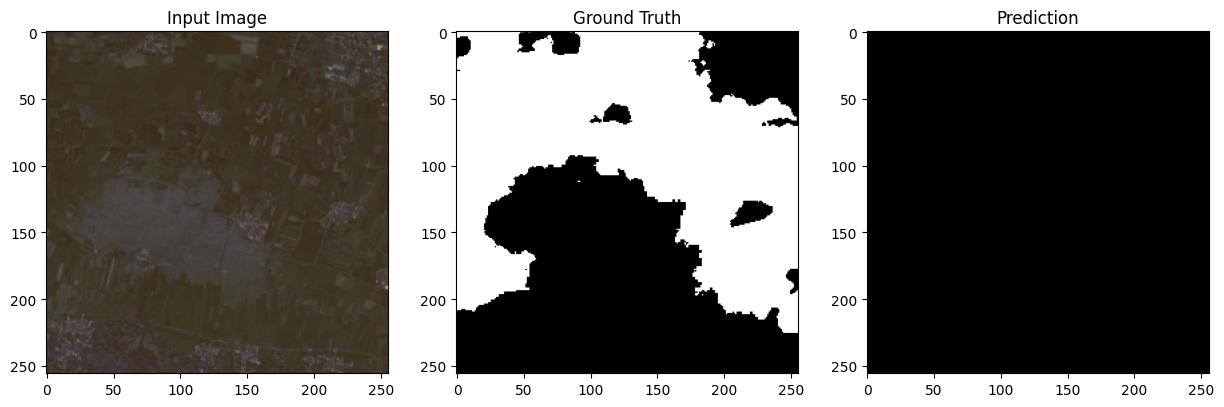

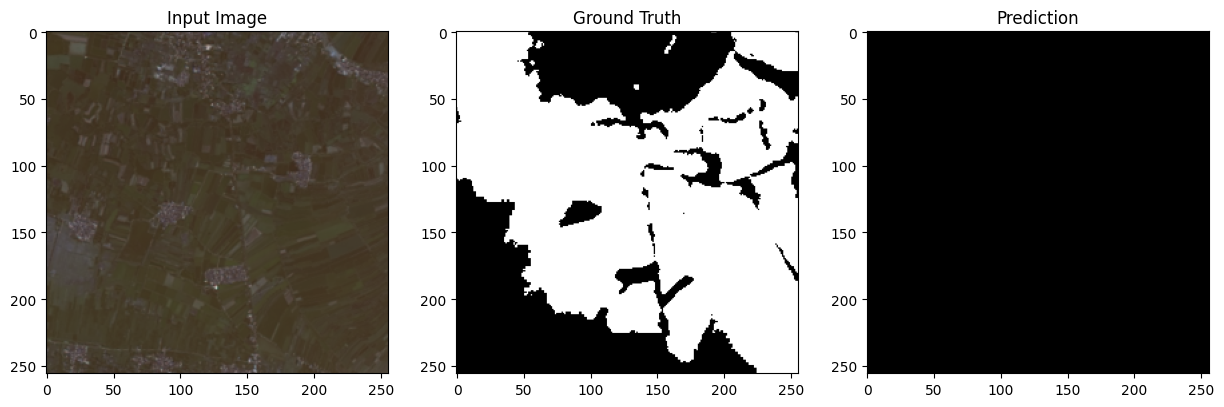

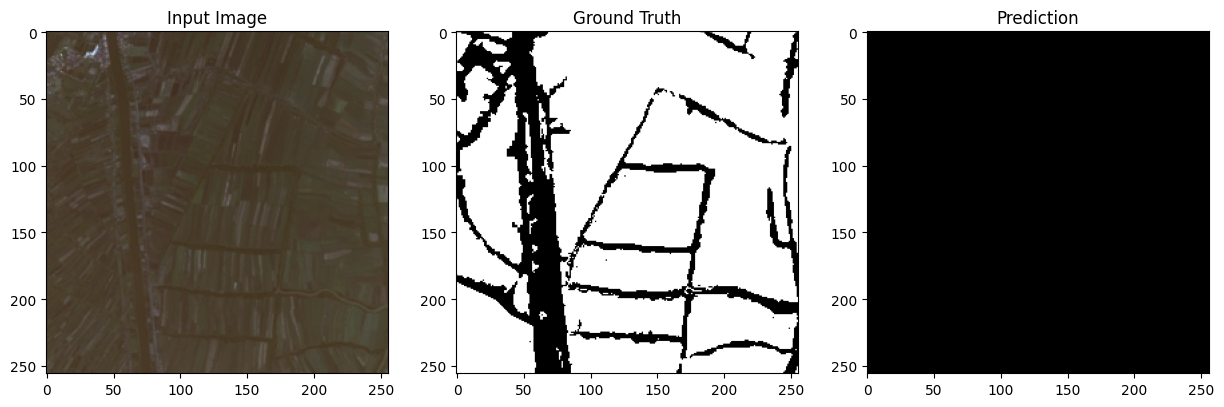

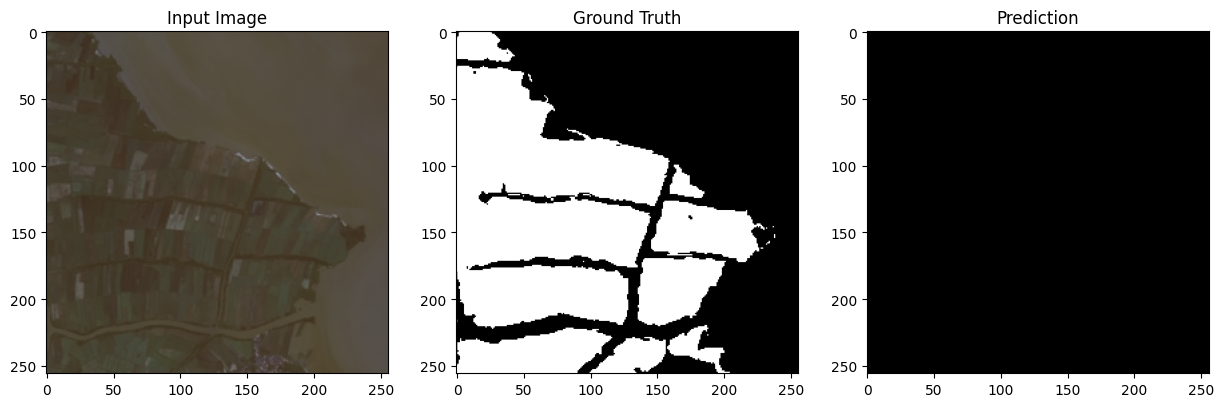

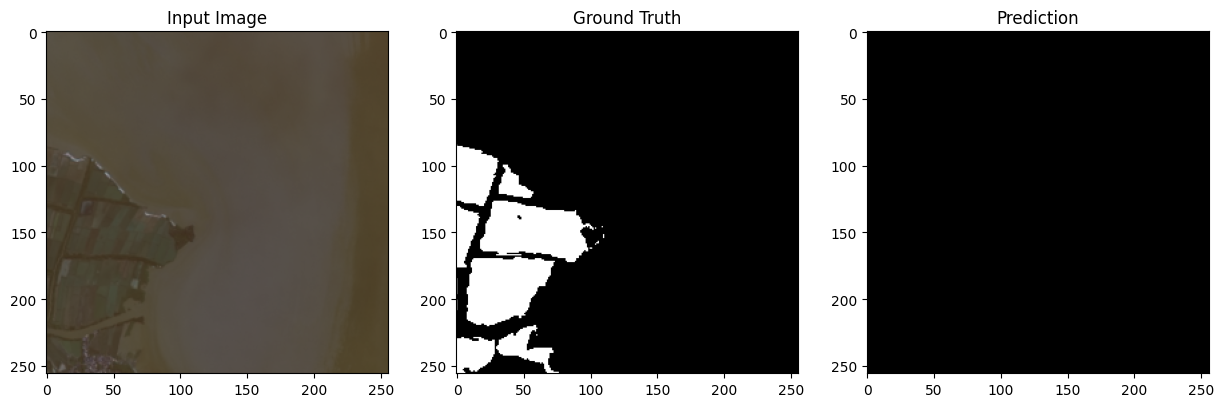

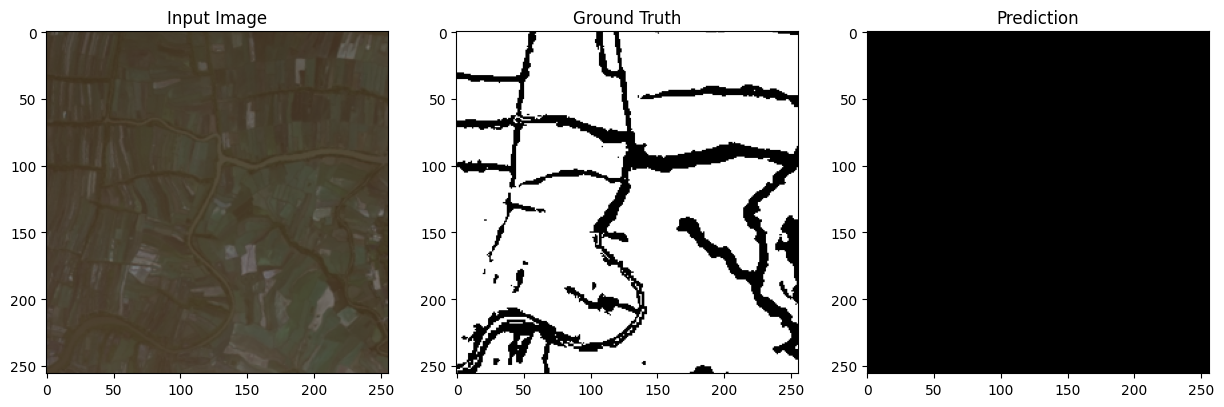

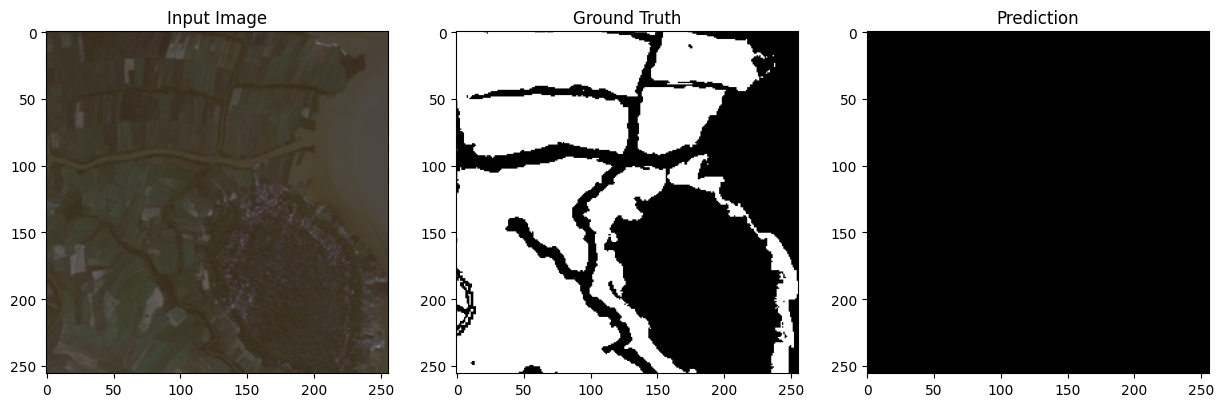

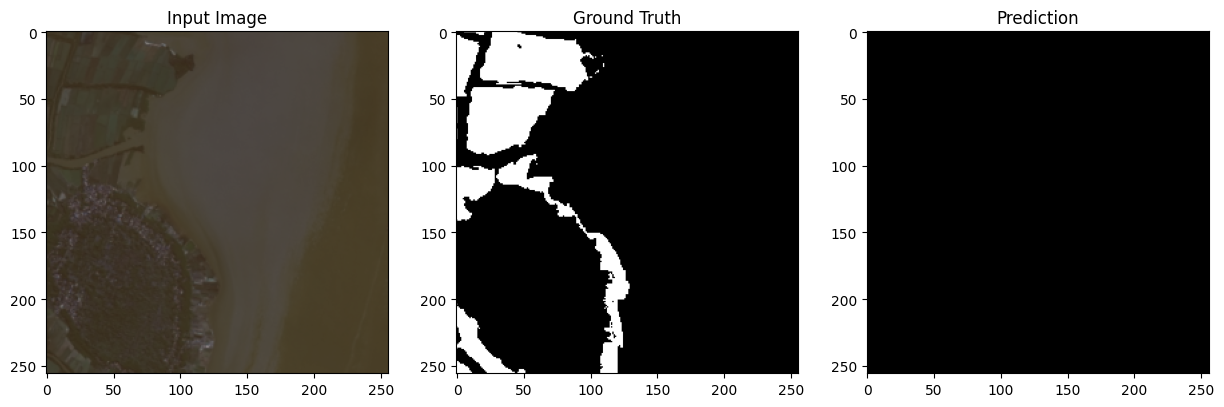

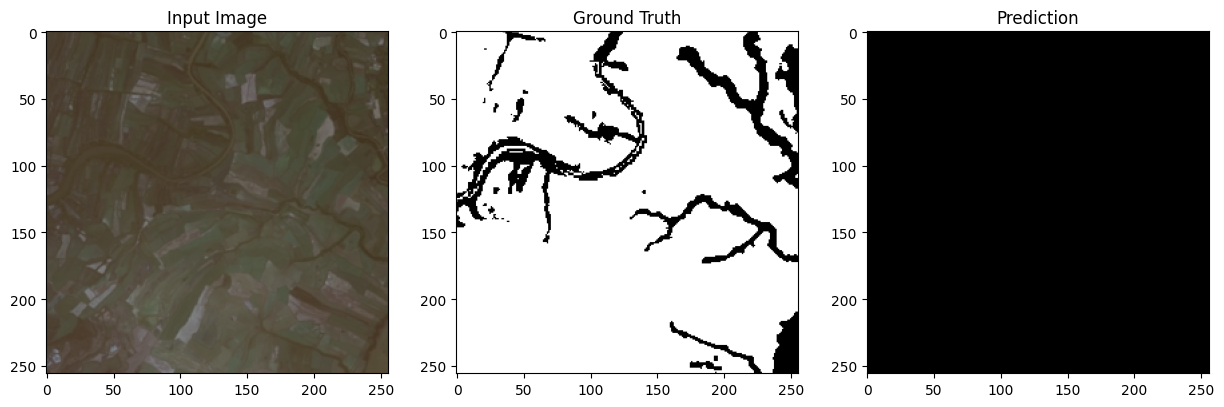

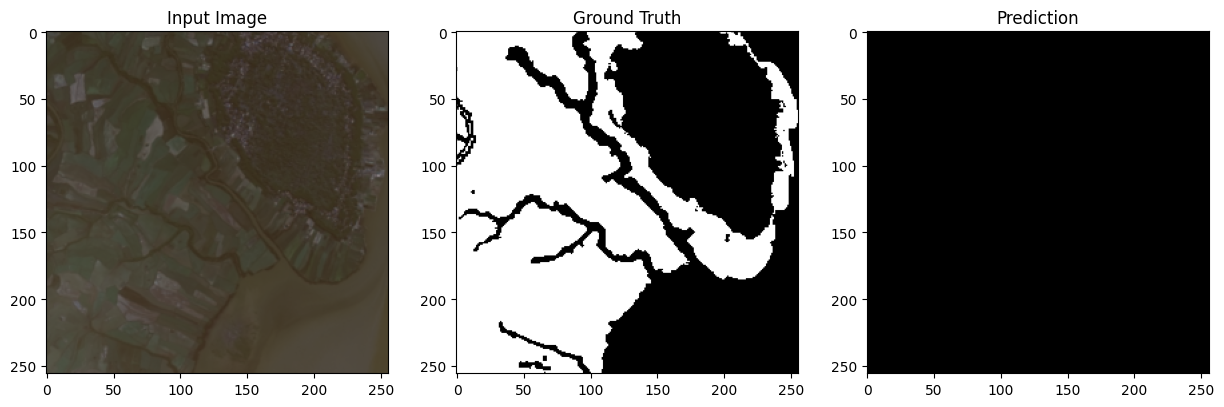

In [30]:
# Function to visualize predictions
def visualize_predictions(model, data_loader, device, num_images=5):
    """Visualize predictions from the model compared to ground truth labels.

    Parameters:
        model (torch.nn.Module): Trained model for segmentation.
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device onde o modelo está rodando.
        num_images (int): Número de imagens para visualizar.
    """
    model.eval()
    images_displayed = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Move data back to CPU for visualization
            images = images.cpu()
            labels = labels.cpu()
            preds = preds.cpu()

            # Visualize predictions compared to ground truth
            for i in range(min(num_images, len(images))):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                # Select only three channels for display or compute mean
                image_display = images[i, :3].permute(1, 2, 0)  # Consider only the first 3 channels

                axs[0].imshow(image_display)
                axs[0].set_title("Input Image")
                axs[1].imshow(labels[i], cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(preds[i], cmap="gray")
                axs[2].set_title("Prediction")
                plt.show()

                images_displayed += 1
                if images_displayed >= num_images:
                    return

# Visualize predictions
visualize_predictions(model, val_loader, device, num_images=5)

In [ ]:
# Save the trained model's state dict
model_path = "/content/gdrive/My Drive/adleo_my/final_project/resunet_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# **References**

Diakogiannis, F. I., Waldner, F., Caccetta, P., & Wu, C. (2020). ResUNet-a: A deep learning framework for semantic segmentation of remotely sensed data. In ISPRS Journal of Photogrammetry and Remote Sensing (Vol. 162, pp. 94–114). Elsevier BV. https://doi.org/10.1016/j.isprsjprs.2020.01.013

Miller, L., Pelletier, C., & Webb, G. I. (2024). Deep Learning for Satellite Image Time Series Analysis: A Review (Version 2). arXiv. https://doi.org/10.48550/ARXIV.2404.03936